https://github.com/bethgelab/foolbox/blob/master/examples/spatial_attack_pytorch_resnet18.py

In [1]:
"""
The spatial attack is a very special attack because it tries to find adversarial
perturbations using a set of translations and rotations rather then in an Lp ball.
It therefore has a slightly different interface.
"""
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import foolbox.attacks as fa
import torch
import foolbox as fb

In [2]:
# instantiate a model (could also be a TensorFlow or JAX model)
# model = models.resnet18(pretrained=True).eval()

model = models.wide_resnet50_2(pretrained=True).eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
# get data and test the model
# wrapping the tensors with ep.astensors is optional, but it allows
# us to work with EagerPy tensors in the following
(images, labels), restore_type = ep.astensors_(*samples(fmodel, dataset="imagenet", batchsize=16))
clean_acc = accuracy(fmodel, images, labels) * 100
print(f"clean accuracy:  {clean_acc:.1f} %")

clean accuracy:  93.8 %


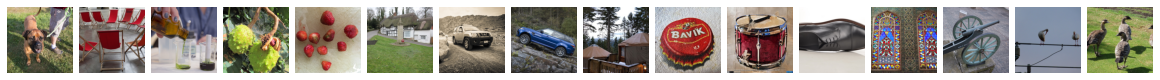

In [10]:
fb.plot.images(images, n=16, scale=1)

In [10]:
images.shape

torch.Size([16, 3, 224, 224])

In [54]:
# the attack trys a combination of specified rotations and translations to an image
# stops early if adversarial shifts and translations for all images are found
# attack = fa.SpatialAttack(
#     max_translation=6,  # 6px so x in [x-6, x+6] and y in [y-6, y+6]
#     num_translations=6,  # number of translations in x, y.
#     max_rotation=20,  # +- rotation in degrees
#     num_rotations=5,  # number of rotations
#     # max total iterations = num_rotations * num_translations**2
# )

attack = fa.FGSM()

# report the success rate of the attack (percentage of samples that could
# be adversarially perturbed) and the robust accuracy (the remaining accuracy
# of the model when it is attacked)
xp_, x_, success = attack(fmodel, images, labels, epsilons=[8./255.])
suc = success.float32().mean().item() * 100
print(
    f"attack success:  {suc:.1f} %"
    " (for the specified rotation and translation bounds)"
)
print(
    f"robust accuracy: {100 - suc:.1f} %"
    " (for the specified rotation and translation bounds)"
)

attack success:  93.8 % (for the specified rotation and translation bounds)
robust accuracy: 6.2 % (for the specified rotation and translation bounds)


In [74]:
nor = restore_type(images[torch.where(restore_type(success).int().cpu().squeeze() == 1)[0]])
nor.shape

torch.Size([15, 3, 224, 224])

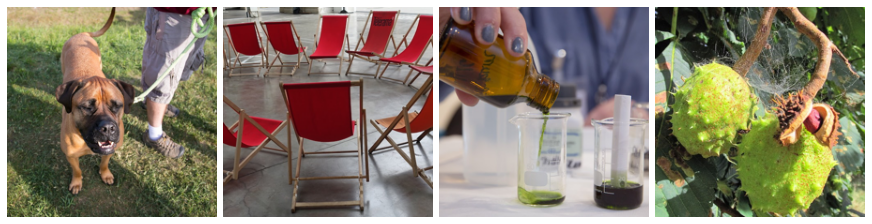

In [77]:
fb.plot.images(nor, n=4, scale=3)

In [82]:
adv = restore_type(x_[0][torch.where(restore_type(success).int().cpu().squeeze() == 1)[0]])
adv.shape

torch.Size([15, 3, 224, 224])

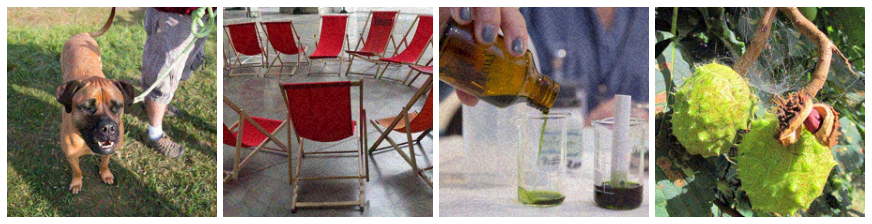

In [83]:
fb.plot.images(adv, n=4, scale=3)

In [16]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

In [17]:
transform_list = [transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()]
transform = transforms.Compose(transform_list)

In [42]:
dataset_dir_path    = "/home/DATA/ITWM/lorenzp/ImageNet/val"
data_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(dataset_dir_path, transform), 
    batch_size=64, shuffle=True, num_workers=8, pin_memory=True
)

In [50]:
restore_type(success).int().cpu().shape

torch.Size([1, 16])

In [66]:
restore_type(success).int().cpu().squeeze().shape

torch.Size([16])

In [58]:
images.shape

torch.Size([16, 3, 224, 224])

In [63]:
x_[0].shape

torch.Size([16, 3, 224, 224])